In [24]:
import numpy as np
import tensorflow as tf 

### **Positional Encoding**  

Transformer는 입력 시퀀스를 병렬적으로 처리하기 때문에, 입력 데이터는 위치정보를 포함하고 있어야 한다.  
Positional Encoding은 각 입베딩 벡터에 위치 정보를 더하는 과정이다.  

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, N, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(N, d_model)
    
    def get_positional_encoding(self, N, d_model):

        def get_pos_formular(pos, i, d_model):
            formular = pos / tf.math.pow(10000, 2*i / tf.cast(d_model, tf.float32))
            return tf.math.sin(formular) if i%2 is 0 else tf.math.cos(formular)

        pos_encoding = [[get_pos_formular(pos, i, d_model) for i in range(d_model)] for pos in range(N)]
        pos_encoding = np.array(pos_encoding)

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding

아래는 50개의 임베딩 벡터, 각 임베딩 벡터의 차원이 128일 때의 포지셔널 인코딩 행렬을 시각화한 것이다.

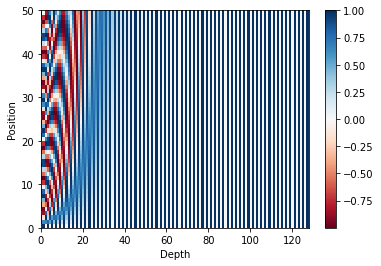

In [26]:
import matplotlib.pyplot as plt

pos_encoder = PositionalEncoding(50, 128)

plt.pcolormesh(pos_encoder.pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### **Padding Mask 생성**  
softmax 함수에 잘못된 값이 들어가는 경우에, 이 값을 연산에서 제외하기 위해 Padding Mask 단계를 거친다.  
mask에 -1e9 값을 곱해 Attention Score 행렬에 더한다.  

> 잘못된 값이란, 입력된 문장 행렬에서 <*PAD*>를 의미한다.  
> <*PAD*> 값을 의미하는 0을 찾아 마스킹한다.

In [27]:
def create_padding_mask(multiple_qk):
    mask = tf.cast(tf.math.equal(multiple_qk,0), tf.float32)
    return mask[:,tf.newaxis, tf.newaxis,:] * -1e9

In [28]:
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  
create_padding_mask(temp_k)

<tf.Tensor: shape=(4, 1, 1, 3), dtype=float32, numpy=
array([[[[-0.e+00, -1.e+09, -1.e+09]]],


       [[[-1.e+09, -0.e+00, -1.e+09]]],


       [[[-1.e+09, -1.e+09, -0.e+00]]],


       [[[-1.e+09, -1.e+09, -0.e+00]]]], dtype=float32)>

### **Scaled Dot-product Attention**  
Dot-product Attention과 유사하나, k 벡터의 차원 값인 d_k의 루트 값을 나눠 scaling하는 과정이 추가되었다.

```
Attention(Q, K, V) = softmax(Q*K^T)*V               # Dot-product Attention
Attention(Q, K, V) = softmax((Q*K^T)/sqrt(d_k))*V   # Scaled Dot-product Attention
```

In [29]:
def scaled_dot_product_attention(query, key, value, mask):

    # Attention Score : Q * K^T
    attention_score_matrix = tf.matmul(query, key, transpose_b=True)
    
    # Scaling : Divide by sqrt(d_k)
    d_k = tf.cast(key.shape[-1], tf.float32)
    scaled_matrix = attention_score_matrix / tf.math.sqrt(d_k)

    # Padding Mask or Look-Ahead Mask
    if mask is not None:
        scaled_matrix += mask

    # Softmax fuction
    attention_weights = tf.nn.softmax(scaled_matrix, axis=-1)

    # Weighted Sum : multiply V matrix
    attention_value = tf.matmul(attention_weights, value)

    return attention_value, attention_weights

아래는 `temp_k`, `temp_v`, `temp_q`가 입력으로 주어졌을 때 Attention Value와 Attention Distribution 을 구한 결과이다.

In [30]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  

In [31]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print("Attention Distribution : {}".format(temp_attn)) 
print("Attention Value : {}".format(temp_out))

Attention Distribution : [[0. 1. 0. 0.]]
Attention Value : [[10.  0.]]


### **Muti-Head Attention**  
한번의 Attention을 수행하는 것보다, 여러번의 Attention을 병렬적으로 수행하는 것이 효율적이다.  
각 Attention을 수행한 결과로부터 각기 다른 관점의 정보를 수집할 수 있다.  

입력된 `query`, `key`, `value` 행렬 값이 각각 `(1, 1, 16)`, `(1, 4, 16)`, `(1, 4, 16)`이고, `d_model`이 16, `num_heads`가 4이라고 가정하자.  
이를 `num_heads`로 분할하여 각각 Attention을 적용하기 위해 입력된 행렬을 다음과 같이 분할한다.

```
(batch_size, num_heads, 입력 시퀀스 개수, d_model / num_heads)
```  
```
query.shape   # (1, 4, 1, 4)
key.shape     # (1, 4, 4, 4)
value.shape   # (1, 4, 4, 4)
```
 
**batch size**  
위 예제에서 batch_size는 1이다.
batch size는 모델 훈련에서의 1 batch 당 사용되는 token의 수를 의미한다.

위 query, key, value Tensor에 scaled dot-product attention을 적용하면  
`q vector=(1, 4)`, `k vector=(4, 4)`, `v vector= (4, 4)`에 대해 4번의 Attention을 각각 적용한 것과 동일하다.

이 후에 `num_heads`로 분할되어 있던 행렬을 이어 `(batch_size, 입력 시퀀스 개수, d_model)`로 변환한다. `

In [32]:
def printShape(Q, K, V, status):
    print("[{status}] Q shape : {q}, K shape : {k}, V shape : {v}\n".format(status=status, q=Q.shape, k=K.shape, v=V.shape))


In [33]:
class MultiHeadAttention:
    def __init__(self, num_heads, d_model):
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0, "depth가 정수 형식이 아닙니다."
        self.depth = self.d_model // self.num_heads

        # Dense 층의 출력 차원은 d_model
        self.WQ = tf.keras.layers.Dense(units=self.d_model)
        self.WK = tf.keras.layers.Dense(units=self.d_model)
        self.WV = tf.keras.layers.Dense(units=self.d_model)
        self.WO = tf.keras.layers.Dense(units=self.d_model)

    
    def get_attention(self, query, key, value, mask=None):

        printShape(query, key, value, "Input")
        
        def split_sequences(batch_size, num_heads, d_model, query, key, value):
            Q_list = tf.reshape(query, (batch_size, -1, num_heads, d_model // num_heads))
            K_list = tf.reshape(key, (batch_size, -1, num_heads, d_model // num_heads))
            V_list = tf.reshape(value, (batch_size, -1, num_heads, d_model // num_heads))

            return tf.transpose(Q_list, perm=[0, 2, 1, 3]), tf.transpose(K_list, perm=[0, 2, 1, 3]), tf.transpose(V_list, perm=[0, 2, 1, 3])
            
        # 현재 batch_size는 1이다.
        # 모델 훈련에서의 batch 당 token의 수를 의미한다.
        batch_size = tf.shape(query)[0]

        # Q*W^Q : Dense 층 구성
        q_WQ = self.WQ(query)
        k_WK = self.WK(key)
        v_WV = self.WV(value)
        printShape(q_WQ, k_WK, v_WV, "Dense")

        # num_heads로 입력 행렬 분할
        # (batch_size, 입력 시퀀스 개수, d_model) -> (batch_size, num_heads, 입력 시퀀스 개수, d_model/num_heads)
        Q_list, K_list, V_list = split_sequences(batch_size, self.num_heads, self.d_model, q_WQ, k_WK, v_WV)
        printShape(Q_list, K_list, V_list, "Splited")

        # Attention value 
        scaled_attention, _ = scaled_dot_product_attention(Q_list, K_list, V_list, mask)
        
        # head를 연결하기 위한 Tensor shape 조정
        # (batch_size, num_heads, 입력 시퀀스 개수, d_model/num_heads) -> (batch_size, 입력 시퀀스 개수, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # head 연결
        # (batch_size, 입력 시퀀스 개수, d_model)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # Multi-Head 최종 결과 값
        result = self.WO(concat_attention)

        return result
        
        

In [34]:
temp_k = tf.constant([[10,0,0,10,0,0,10,0,0,10,0,0,10,0,0,1],
                      [0,10,0,0,10,0,0,10,0,0,10,0,0,10,0,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0,    2,0,    3,0,    4,0,    5,0,    6,0,    7,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0],
                      [  12,0,   10,0,   10,0,   10,0,   11,0,   10,0,   13,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0],
                      [ 123,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5],
                      [1111,6, 1320,6, 1034,6, 1000,6, 1019,6, 1110,6, 1031,6, 1330,6, 1032,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6]], dtype=tf.float32)  

temp_q = tf.constant([[0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,1]], dtype=tf.float32)

attention = MultiHeadAttention(4, 16)
result = attention.get_attention(temp_q, temp_k, temp_v, None)
print("Multi-Head Attention Output : {}".format(result))
print("Attention Output shape : {}".format(result.shape))

[Input] Q shape : (1, 16), K shape : (4, 16), V shape : (4, 32)

[Dense] Q shape : (1, 16), K shape : (4, 16), V shape : (4, 16)

[Splited] Q shape : (1, 4, 1, 4), K shape : (1, 4, 4, 4), V shape : (1, 4, 4, 4)

Multi-Head Attention Output : [[[-309.82806  -419.08362   306.7626    349.20847   451.06757
   -263.09796   417.1777    257.14594   535.4756    317.0679
    392.20667   255.43399   -89.17638  -304.13898   104.8978
     31.428625]]]
Attention Output shape : (1, 1, 16)


### **Encoder**  
`class Encoder`는 `layer_num`만큼 인코더 층을 쌓은 객체이다.  
각 layer는 keras.Model을 반환하는데, 입력 값으로 `inputs`의 크기를 가지고  
출력 값은 `inputs`에 대한 함수 수행 결과를 반환한다.  

각 encoder layer에서는 Self-Attention, Feed Forward Network를 수행한다.

In [47]:
class Encoder:
    def __init__(self, N, layer_num, dff, d_model, num_heads, dropout=None):
        self.N = N
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout

    def stack_encode_layer(self, layer_name):
        print(layer_name)
        
        # Input 2개  : 인코더 입력, padding mask
        inputs = tf.keras.Input(shape=(None, self.d_model), name="encode_inputs")
        pad_mask = tf.keras.Input(shape=(1, 1, None), name= "encoder_padding_mask")

        # encoder의 self attention은 query, key, value가 모두 입력 문장의 단어 벡터를 의미한다.
        # query = key = value
        query = key = value = inputs
        
        # Multi-Head Attention
        multi_head_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = multi_head_attention.get_attention(query, key, value, mask=pad_mask)

        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += inputs
        # Normalization
        sublayer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        # Feed Forward Network
        # 입력과 출력의 크기가 보존되며, FFN의 은닉층 크기는 dff다.
        feed_forward_net = tf.keras.layers.Dense(units=self.dff, activation='relu')(sublayer_output)
        feed_forward_net = tf.keras.layers.Dense(units=self.d_model)(feed_forward_net)
        
        feed_forward_net = tf.keras.layers.Dropout(rate=0.1)(feed_forward_net)
        # Residual connection
        feed_forward_net += sublayer_output
        # Normalization
        encoder_layer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(feed_forward_net)

        return tf.keras.Model(inputs=[inputs, pad_mask], outputs=encoder_layer_output, name=layer_name)

    def get_encoder(self):

        inputs = tf.keras.Input(shape=(None, self.d_model), name="encoder_inputs")
        pad_mask = tf.keras.Input(shape=(1, 1, None), name= "encoder_padding_mask")

        # Positional Encoding
        encoder_input = PositionalEncoding(self.N, self.d_model)(inputs)
        
        # Encoder Layer 쌓기
        # layer_num 만큼 encoder layer를 쌓는다
        for idx in range(self.layer_num):
            encoder_input = encoder_output = self.stack_encode_layer(layer_name="encoder_layer_{}".format(idx))(inputs=[encoder_input, pad_mask])

        return tf.keras.Model(inputs=[inputs, pad_mask], outputs=encoder_output, name="Encoder")


### **Look-Ahead Mask 생성**  
Transformer의 디코더는 순차적인 입력이 아니라 문장 행렬로 한꺼번에 입력되기 때문에,  
현재 단어를 예측할 때 미래 시점의 단어가 개입되는 문제가 발생한다.  

이를 방지하기 위해, 현재보다 이후 시점의 단어는 마스킹하여 미리보기를 방지한다.  
또한 <*PAD*> 값을 포함하지 않도록 Pad Masking도 수행한다. 

In [36]:
def create_look_ahead_mask(attention_score_matrix):
    N = tf.shape(attention_score_matrix)[1]

    mask = tf.ones(shape=(N,N), dtype=tf.float32)
    #mask = tf.experimental.numpy.triu(mask, 1) * -1e9 
    mask = 1 - tf.linalg.band_part(mask, -1, 0) * -1e9

    pad_mask = create_padding_mask(attention_score_matrix)
    return tf.maximum(mask, pad_mask)

In [37]:
tmp = tf.constant([[1, 2, 0, 4, 5]])
create_look_ahead_mask(tmp)

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[1.e+09, 1.e+00, 1.e+00, 1.e+00, 1.e+00],
         [1.e+09, 1.e+09, 1.e+00, 1.e+00, 1.e+00],
         [1.e+09, 1.e+09, 1.e+09, 1.e+00, 1.e+00],
         [1.e+09, 1.e+09, 1.e+09, 1.e+09, 1.e+00],
         [1.e+09, 1.e+09, 1.e+09, 1.e+09, 1.e+09]]]], dtype=float32)>

### **Decoder**  
`class Decoder` 또한 `layer_num`만큼 층을 쌓은 객체이다.  
입력 값은 `d_model`의 차원을 가지며, 출력 값으로 `inputs`에 대한 함수 수행 결과를 반환한다.  

각 decoder layer에서는 Masked Self-Attention, Encoder-Decoder, Feed Forward Network를 수행한다.

In [46]:
class Decoder:
    def __init__(self, N, layer_num, dff, d_model, num_heads, dropout=None):
        self.N = N
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout

    def stack_decode_layer(self, layer_name):
        print(layer_name)
        
        #Input 4개 : 디코더 입력, 인코더 출력, Look-ahead mask, padding mask
        decoder_input = tf.keras.Input(shape=(None, self.d_model), name="decoder_layer_input")
        encoder_output = tf.keras.Input(shape=(None, self.d_model), name="encoder_output")

        look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
        pad_mask = tf.keras.Input(shape=(1, 1, None), name= "decoder_padding_mask")

        # Masked Multi-Head Self Attention
        # 디코더의 Self Attention에서 query, key, value의 출처는 디코더 입력이다.
        query = key = value = decoder_input

        self_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = self_attention.get_attention(query, key, value, mask=look_ahead_mask)

        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += decoder_input
        # Normalization
        sublayer_output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        # Multi-Head Encoder-Decoder Attention
        # 디코더 Encoder-Decoder Attention의 입력 중 Q는 디코더 sub-layer의 출력이고, K,V는 인코더의 출력이다.
        key_from_encoder = value_from_encoder = encoder_output
        query_from_decoder = sublayer_output_1

        print("Sub-Layer2")
        # 두번째 Encoder-Decoder Attention은 padding masking을 수행한다.
        encoder_decoder_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = encoder_decoder_attention.get_attention(query_from_decoder, key_from_encoder, value_from_encoder, mask=pad_mask)

        print("Add & Lorm2")
        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += sublayer_output_1
        # Normalization
        sublayer_output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        print("Feed Forward")
        # Feed Forward Network
        # 입력과 출력의 크기가 보존되며, FFN의 은닉층 크기는 dff다.
        feed_forward_net = tf.keras.layers.Dense(units=self.dff, activation='relu')(sublayer_output_2)
        feed_forward_net = tf.keras.layers.Dense(units=self.d_model)(feed_forward_net)

        print("Add & Norm 3")
        feed_forward_net = tf.keras.layers.Dropout(rate=0.1)(feed_forward_net)
        # Residual connection
        feed_forward_net += sublayer_output_2
        # Normalization
        decoder_layer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(feed_forward_net)

        return tf.keras.Model(inputs=[decoder_input, encoder_output, look_ahead_mask, pad_mask], outputs=decoder_layer_output, name=layer_name)


    def get_decoder(self):
        
        #Input 4개 : 디코더 입력, 인코더 출력, Look-ahead mask, padding mask
        decoder_input = tf.keras.Input(shape=(None, self.d_model), name="decoder_inputs")
        encoder_output = tf.keras.Input(shape=(None, self.d_model), name="encoder_outputs")

        look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
        pad_mask = tf.keras.Input(shape=(1, 1, None), name= "decoder_padding_mask")

        # Positional Encoding
        input = PositionalEncoding(self.N, self.d_model)(decoder_input)
        
        # Decoder Layer 쌓기
        # layer_num 만큼 decoder layer를 쌓는다
        for idx in range(self.layer_num):
            input = decoder_output = self.stack_decode_layer(layer_name="decoder_layer_{}".format(idx))(inputs=[input, encoder_output, look_ahead_mask, pad_mask])

        return tf.keras.Model(inputs=[decoder_input, encoder_output, look_ahead_mask, pad_mask], outputs=decoder_output, name="Decoder")


### **Transformer**  
`class Transformer`는 트랜스포머 모델의 객체이다.  
`layer_num` 만큼 인코더와 디코더를 쌓고, 인코더 결과 값을 디코더에 연결한다.  

디코더의 출력 값을 통해, 다음 단어를 예측한다.  

In [52]:
class Transformer:
    def __init__(self, vocab_size, layer_num, dff, d_model, num_heads):
        self.vocab_size = vocab_size
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads

    '''
    encoder input : 인코더의 입력은, 요약하지 않은 문장을 토큰화하여 임베딩한 벡터들.
    decoder input : 디코더의 입력은 요약된 문장을 토큰화하여 임베딩한 벡터들.
    '''
    def get_transformer(self):
        
        #Input 2개 : 인코더 입력, 디코더 입력
        encoder_input = tf.keras.Input(shape=(None,), name="encoder_inputs")
        decoder_input = tf.keras.Input(shape=(None,), name="decoder_inputs")

        #인코더
        encoder_pad_mask= tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='encoder_padding_mask')(encoder_input)

        print(encoder_pad_mask)
        encoder = Encoder(self.vocab_size, self.layer_num, self.dff, self.d_model, self.num_heads)
        encoder_output = encoder.get_encoder()(inputs=[encoder_input, encoder_pad_mask])

        #디코더
        look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='decoder_look_ahead_mask')(decoder_input)
        decoder_pad_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='decoder_padding_mask')(encoder_input)
        
        print(look_ahead_mask)
        print(decoder_pad_mask)
        
        decoder = Decoder(self.vocab_size, self.layer_num, self.dff, self.d_model, self.num_heads)
        decoder_output = decoder.get_decoder()(inputs=[decoder_input, encoder_output, look_ahead_mask, decoder_pad_mask])

        '''
        디코더에서는 인코더의 행렬과 디코더의 입력을 통해 다음 단어를 예측한다.
        디코더의 출력은 임베딩 벡터의 개수 vocab size의 크기를 가지며, 확률 값을 가진다.
        '''
        # 단어 예측을 위한 출력층
        output = tf.keras.layers.Dense(units=self.vocab_size, name="Output")(decoder_output)

        return tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=output, name="Transformer")


```
vocab_size  # 입력 시퀀스 길이
layer_num   # 인코더/디코더 층
dff         # FFN의 셀 개수
num_heads   # Multi-head Attention 수행 시 head 개수
```

In [53]:
transformer = Transformer(
    vocab_size = 9000,
    layer_num = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4)

model = transformer.get_transformer()

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name=None), name='encoder_padding_mask/mul:0', description="created by layer 'encoder_padding_mask'")
encoder_layer_0
[Input] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128)

[Dense] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128)

[Splited] Q shape : (None, 4, None, 32), K shape : (None, 4, None, 32), V shape : (None, 4, None, 32)

encoder_layer_1
[Input] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128)

[Dense] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128)

[Splited] Q shape : (None, 4, None, 32), K shape : (None, 4, None, 32), V shape : (None, 4, None, 32)

encoder_layer_2
[Input] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128)

[Dense] Q shape : (None, None, 128), K shape : (None, None, 128), V shape : (None, None, 128

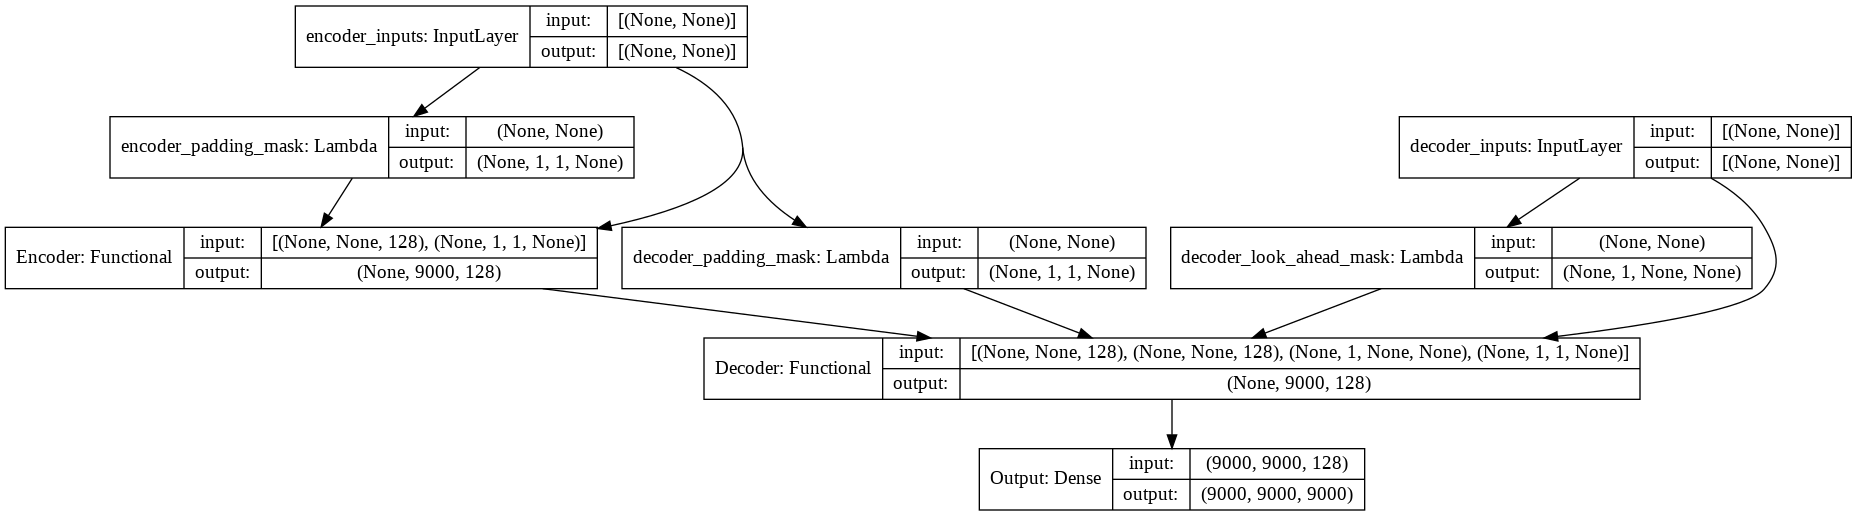

In [54]:
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True)